문제 정의: LinearRegression 단순 회귀 분석 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비(MPG) 예측

기본 라이브러리 불러오기

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 한글 깨짐 방지
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


[Step 1] 데이터 준비 - read_csv() 함수로 자동차 연비 데이터셋 가져오기

In [3]:
# csv 파일을 데이터프레임으로 변환
df = pandas.read_csv('/content/auto-mpg.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [4]:
# 열 이름 지정
df.columns = ['mpg','cylinders','displacement','horsepower','weight',
              'acceleration','model year','origin','name']

데이터 살펴보기

In [5]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


[Step 2] 데이터 탐색 및 데이터 전처리

In [6]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [7]:
# horsepower 열의 자료형 (문자열 -> 숫자)
df['horsepower'].unique()

array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

In [8]:
# '?'를 numpy.nan으로
df['horsepower'].replace('?', numpy.nan, inplace = True)

In [9]:
# 누락 데이터(numpy.nan)를 삭제
df.dropna(subset = ['horsepower'], axis = 0, inplace = True)

In [10]:
# 문자열 -> 숫자로 변환
df['horsepower'] = df['horsepower'].astype('float')

[Step 3] 속성(feature 또는 variable) 선택

In [11]:
# 분석에 활용할 속성을 선택 (연비, 실린더, 출력(마력), 중량)
ndf = df[['mpg', 'cylinders', 'horsepower', 'weight']]
ndf.head()

,mpg,cylinders,horsepower,weight
0,18.0,8,130.0,3504.0
1,15.0,8,165.0,3693.0
2,18.0,8,150.0,3436.0
3,16.0,8,150.0,3433.0
4,17.0,8,140.0,3449.0


[Step 4] 데이터셋 구분 - 훈련용(train data)/ 검증용(test data)

In [12]:
# 속성(변수) 선택 -> 단순회귀
X = ndf[['weight']] # 독립변수는 2차원으로 만들어줘야하기 때문에 []안에 []
y = ndf['mpg']

In [13]:
# train data 와 test data로 구분(7:3 비율)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,                  # 독립 변수
                                                    y,                  # 종속 변수
                                                    test_size = 0.3,    # 검증 30%
                                                    random_state = 10)  # 랜덤 추출 값 (시드)

[Step 5] 단순회귀분석 모형 - sklearn 사용

In [14]:
# sklearn 라이브러리에서 선형회귀분석 모듈 가져오기
from sklearn.linear_model import LinearRegression

# 단순회귀분석 모형 객체 생성 후 학습시키기
lr = LinearRegression().fit(X_train, y_train)

[Step 6] 성능 평가하기

In [15]:
r_square = lr.score(X_test, y_test)
r_square

0.6822458558299322

In [16]:
# 모형에 전체 X 데이터를 입력하여 예측한 값을 y_hat으로 담기
y_hat = lr.predict(X)

In [17]:
# 모형에 테스트셋 X_test 데이터를 입력하여 예측한 값을 y_hat_test으로 담기
y_hat_test = lr.predict(X_test)

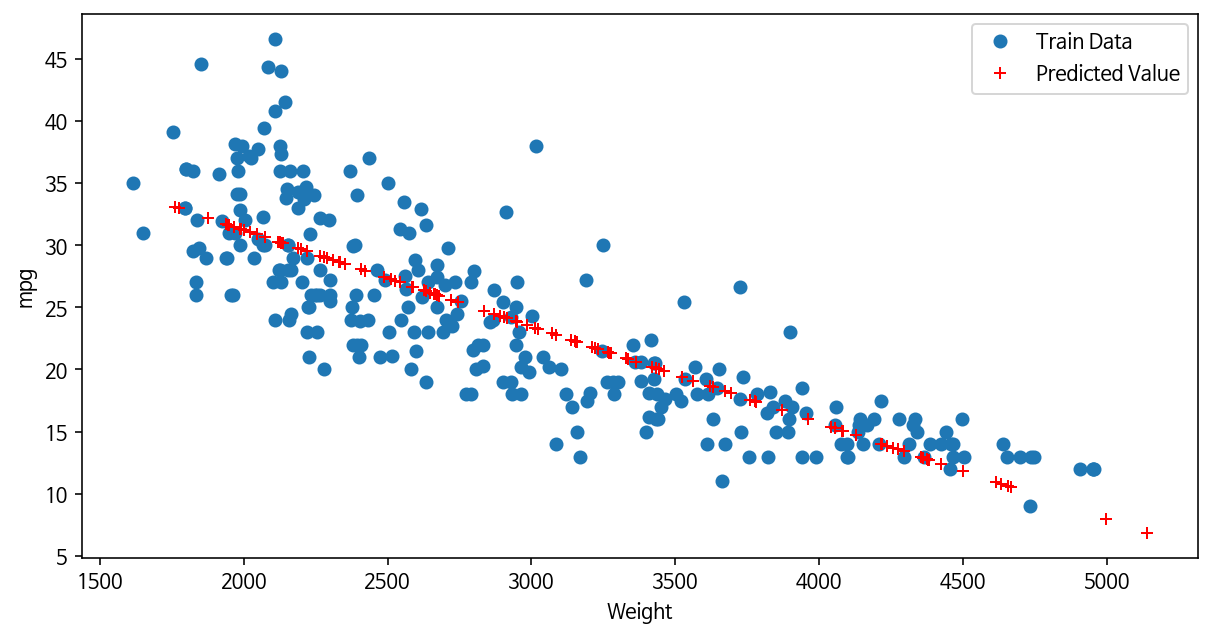

In [18]:
# train 데이터(X_train)의 산점도와 test 데이터(X_test)로 예측한 (y_hat_test) 회귀선을 그래프로 출력

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(X_train, y_train, 'o', label = 'Train Data')  # 데이터의 분포
ax.plot(X_test, y_hat_test, 'r+', label = 'Predicted Value')  # 모형이 예측한 회귀선
ax.legend(loc = 'best')
plt.xlabel('Weight')
plt.ylabel('mpg')
plt.show()

In [19]:
print('훈련 세트 정확도 :{:.2f}%'.format(lr.score(X_train, y_train)*100))
print('테스트 세트 정확도 :{:.2f}%'.format(lr.score(X_test, y_test)*100))

훈련 세트 정확도 :69.17%
테스트 세트 정확도 :68.22%


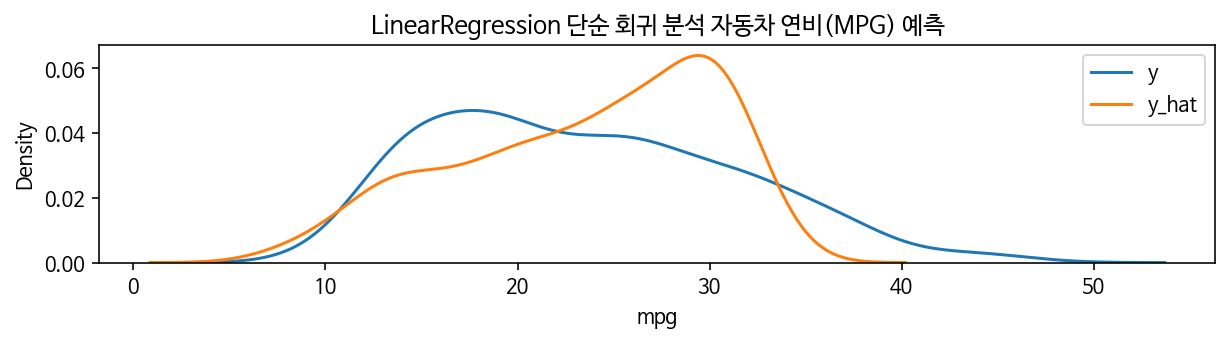

In [20]:
plt.figure(figsize = (10, 2))
ax1 = sns.kdeplot(y, label = 'y')
ax2 = sns.kdeplot(y_hat, label = 'y_hat', ax=ax1)
plt.title('LinearRegression 단순 회귀 분석 자동차 연비(MPG) 예측')
plt.legend()
plt.show()